In [8]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import scipy.stats

import pickle
import methods.util as util
import methods.shared as shared
import methods.sim_barcodes as sim

In [9]:
## Summary of high-frequency, high-fitness barcodes 

expt = 'E1'
fit_barcodes = {}
mouse_specific_high_frequency_barcodes = {}

mice_in_each_col = [(1,2,3,4,5), (6,7,8,9,10), (11,12,13)]
init_day, fin_day = 9, 15

SD_growth_rates = {}
MD_growth_rates = {}
for col, (m_set, colors, title) in enumerate( zip(mice_in_each_col, ['Blues', 'Oranges', 'Reds'], ['SD (P2)', 'SD (P1)', 'MD (P1)']) ):
    for single_mouse in m_set:
        large_indices = shared.find_large_barcodes(expt, [single_mouse], max_cutoff=1e-2, final_cutoff=1)
        mouse_specific_high_frequency_barcodes[single_mouse] = large_indices
        #### record high frequency barcodes in each mouse
        for barcode in shared.barcodes[large_indices]:
            if barcode not in fit_barcodes:
                fit_barcodes[barcode] = []
            fit_barcodes[barcode].append(single_mouse)

        ### estimate exponential growth rates
        if single_mouse in [4,5,6,7]:  ###  exclude cross-housed mice
            continue
        if single_mouse in [1,2,3,8,9,10]:
            diet_growth_rates = SD_growth_rates
        elif single_mouse in [11,12,13]:
            diet_growth_rates = MD_growth_rates


        days, rows, cec = shared.mouse_meta[expt][single_mouse]
        freqs, Deff = shared.freq_array[rows], shared.Deff_array[rows]

        # fig, ax = plt.subplots()
        for barcode_idx in large_indices:
            barcode = shared.barcodes[barcode_idx]
            bc_freqs = freqs[:,barcode_idx]
            
            final_idx = np.where(bc_freqs > 10**-2)[0][0]
            try:
                init_idx = np.where(bc_freqs[:final_idx] < 10**-3)[0][-1]
            except:
                init_idx = 0

            t0, t1 = days[init_idx], days[final_idx]
            if t1 > 21:
                continue
            dt = t1-t0
            f0, f1 = bc_freqs[init_idx], bc_freqs[final_idx]
            D0, D1 = Deff[init_idx], Deff[final_idx]
            mm_f0, mm_f1 = shared.maxmin_freqs([f0], D0, [f1], D1)

            growth_rate = np.log(mm_f1/mm_f0)[0]/dt
            if barcode not in diet_growth_rates:
                diet_growth_rates[barcode] = []
            diet_growth_rates[barcode].append((single_mouse, growth_rate, (t0,t1), (f0*D0,f1*D1)))
            
            # if growth_rate > 1:
            #     ax.plot(days, bc_freqs)

SD_lst, MD_lst = [], []
for (diet, filtered_lst, diet_growth_rates) in [('SD', SD_lst, SD_growth_rates), ('MD', MD_lst, MD_growth_rates)]:
    for b, (barcode, bc_growths) in enumerate(diet_growth_rates.items()):
        growth_rates = np.array([g[1] for g in bc_growths]) 
        if len(growth_rates) == 0: continue
        filtered_lst.append(np.median(growth_rates)) # append the smallest fitness, for barcodes with estimates in multiple mice


    print(f'Diet {diet}: num_high_freq barcodes (>1%):', len(filtered_lst))
    print('List of growth rates:', [float(f'{g:.2f}') for g in filtered_lst])
    print('Min, max growth rate in first 3 weeks (/day):', f'{np.min(filtered_lst):.2f}, {np.max(filtered_lst):.2f}')
    print('25th, median, 75th percentile:', f'{np.percentile(filtered_lst, 25):.2f}, {np.median(filtered_lst):.2f}, {np.percentile(filtered_lst, 75):.2f}')
    print('\n')

MD_lst, SD_lst = np.array(MD_lst), np.array(SD_lst)
print('1-sided Mann Whitney test for MD > SD growths', scipy.stats.mannwhitneyu(MD_lst, SD_lst, alternative='greater'))

with open(f'../data/pickled/E1_large_barcodes.pkl', 'wb') as f:
    pickle.dump(fit_barcodes, f)

Diet SD: num_high_freq barcodes (>1%): 70
List of growth rates: [0.49, 2.22, 0.88, 0.37, 0.33, 0.33, 0.46, 0.54, 0.41, 0.61, 0.48, 0.27, 0.18, 0.46, 1.21, 1.82, 0.17, 1.06, 0.25, 0.55, 0.24, 0.19, 0.4, 0.23, 0.34, 0.24, 0.34, 0.46, 0.86, 2.42, 0.17, 1.08, 0.82, 0.26, 0.92, 0.83, 0.6, 1.1, 0.28, 0.33, 0.27, 0.34, 0.92, 0.37, 0.37, 0.51, 1.02, 0.4, 0.59, 0.75, 0.18, 0.47, 0.71, 0.32, 0.9, 0.38, 0.31, 0.54, 0.32, 1.23, 1.29, 0.76, 0.27, 0.64, 0.81, 0.8, 1.1, 0.51, 0.3, 0.39]
Min, max growth rate in first 3 weeks (/day): 0.17, 2.42
25th, median, 75th percentile: 0.32, 0.46, 0.82


Diet MD: num_high_freq barcodes (>1%): 16
List of growth rates: [1.03, 1.89, 1.31, 1.09, 0.93, 0.62, 1.07, 0.59, 1.67, 1.74, 4.17, 0.72, 0.17, 0.24, 0.65, 0.25]
Min, max growth rate in first 3 weeks (/day): 0.17, 4.17
25th, median, 75th percentile: 0.62, 0.98, 1.40


1-sided Mann Whitney test for MD > SD growths MannwhitneyuResult(statistic=783.0, pvalue=0.006771234659289115)


Num barcodes considered for lfc calculation in SD (P2), mouse 1: 6038 	 75.4% of input barcodes, freq range = (4.46e-05, 6.43e-04)
Num barcodes considered for lfc calculation in SD (P2), mouse 2: 6038 	 75.4% of input barcodes, freq range = (4.46e-05, 6.43e-04)
Num barcodes considered for lfc calculation in SD (P2), mouse 3: 6038 	 75.4% of input barcodes, freq range = (4.46e-05, 6.43e-04)
Num barcodes considered for lfc calculation in SD (P1), mouse 8: 6999 	 73.2% of input barcodes, freq range = (3.94e-05, 5.17e-04)
Num barcodes considered for lfc calculation in SD (P1), mouse 9: 6999 	 73.2% of input barcodes, freq range = (3.94e-05, 5.17e-04)
Num barcodes considered for lfc calculation in SD (P1), mouse 10: 6999 	 73.2% of input barcodes, freq range = (3.94e-05, 5.17e-04)
Num barcodes considered for lfc calculation in MD (P1), mouse 11: 6999 	 73.2% of input barcodes, freq range = (3.94e-05, 5.17e-04)
Num barcodes considered for lfc calculation in MD (P1), mouse 12: 6999 	 73.2% of

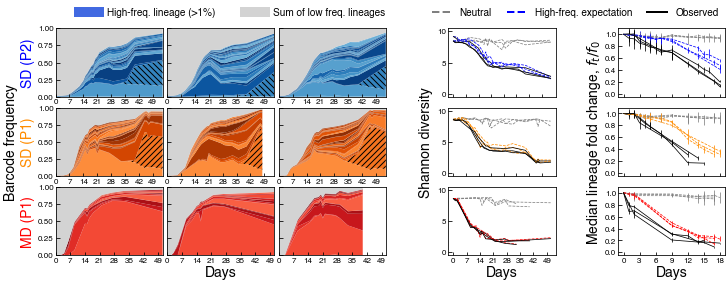

In [10]:
expt = 'E1'

fig = plt.figure(figsize=(12, 4.5))
outer = mpl.gridspec.GridSpec(nrows=4, ncols=7, wspace=0.05, height_ratios=[0.1, 1, 1, 1], width_ratios=(1,1,1,0.5,1,0.5,1), figure=fig)
outer_ax = fig.add_subplot(outer[1:, :3])
outer_ax.set_xlabel('Days', fontsize=14, labelpad=10)
outer_ax.set_ylabel('Barcode frequency', fontsize=14, labelpad=38)
util.turn_off_ax(outer_ax)

legend_ax = fig.add_subplot(outer[0, :4])
util.turn_off_ax(legend_ax)
legend_markers = [ mpl.lines.Line2D((0,), (0,), color='royalblue',  linestyle='solid', lw=10),
                    mpl.lines.Line2D((0,), (0,), color='lightgrey', linestyle='solid', lw=10),]
legend_ax.legend(legend_markers, ['High-freq. lineage (>1%)', 'Sum of low freq. lineages'] , loc=(0.05, -0.5), ncol=2, frameon=False, fontsize=10, columnspacing=3)


mice_in_each_row = [(1,2,3), (8,9,10), (11,12,13)]

muller_colors = {'SD (P2)':'blue', 'SD (P1)':'darkorange', 'MD (P1)':'red'}
for row, (mice_set, colormaps, title) in enumerate( zip(mice_in_each_row, 

                                                  [(('P2', 'Blues'), ('P1', 'Oranges'), ('E1_ambiguous', 'Blues')),
                                                   (('P2', 'Blues'), ('P1', 'Oranges'),  ('E1_ambiguous', 'Oranges')),
                                                   (('P2', 'Reds'), ('P1', 'Reds'), ('E1_ambiguous', 'Reds'))], 
                                                   
                                                  ['SD (P2)', 'SD (P1)', 'MD (P1)']) ):
    large_indices = shared.find_large_barcodes(expt, mice_set, max_cutoff=1e-2, final_cutoff=2)

    
    ordered_indices, ordered_colors = shared.order_barcodes_by_pool(large_indices, shared.barcode_pool_assignments,
                                                                     colormaps, cg_at_end=True, cg_all_low_freqs=True)
    for col, mouse in enumerate(mice_set):
        days, freqs = shared.make_muller_freqs(expt, mouse, ordered_indices, 18)
        ax = fig.add_subplot(outer[row+1, col])
        shared.muller_plot(ax, days, ordered_indices, freqs, ordered_colors, shared.highlight_barcode_hatches)

        if 'format':
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 54)
            ax.set_xticks([0, 7, 14, 21, 28, 35, 42, 49])
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

            if row == 2:
                ax.set_xlim(0, 51)
            if col == 0:
                ax.set_ylabel(title, color=muller_colors[title], fontsize=14, labelpad=3)
            if col > 0:
                ax.set_yticklabels([])

### Entropy column
legend_ax = fig.add_subplot(outer[0, 4:])
util.turn_off_ax(legend_ax)
legend_markers = [
                    mpl.lines.Line2D((0,), (0,), color='grey', linestyle='dashed', lw=2),
                    mpl.lines.Line2D((0,), (0,), color='blue', linestyle='dashed', lw=2),
                    mpl.lines.Line2D((0,), (0,), color='black', mfc='None', markersize=4, lw=2)]
legend_ax.legend(legend_markers, ['Neutral', 'High-freq. expectation', 'Observed'], loc=(-0.075, -0.5), ncol=3, frameon=False, fontsize=10, columnspacing=1.5)


entropy_outer = fig.add_subplot(outer[1:, 4])
util.turn_off_ax(entropy_outer)
entropy_outer.set_ylabel('Shannon diversity', fontsize=14, labelpad=15)
entropy_outer.set_xlabel('Days', fontsize=14, labelpad=10)

median_fc_outer = fig.add_subplot(outer[1:, 6])
util.turn_off_ax(median_fc_outer)
# median_fc_outer.set_ylabel('Median fold change (mean fitness)', fontsize=14)
median_fc_outer.set_ylabel('Median lineage fold change, $f_t/f_0$', fontsize=14, labelpad=15)
median_fc_outer.set_xlabel('Days', fontsize=14, labelpad=10)

min_freq = 0
Ntau = 10**6 #days
MIN_GROUP_SIZE = 30
for z, (m_set, colors, inoc_bool, title) in enumerate( zip(mice_in_each_row, 
                                                ['blue', 'darkorange', 'red'],
                                                [shared.barcode_pool_assignments['P2'][1], shared.barcode_pool_assignments['P1'][1], shared.barcode_pool_assignments['P1'][1]],
                                                ['SD (P2)', 'SD (P1)', 'MD (P1)']) ):
    entropy_ax = fig.add_subplot(outer[z+1, 4])
    ax = fig.add_subplot(outer[z+1, 6])


    for m, mouse in enumerate(m_set):
        days = shared.mouse_meta['E1'][mouse][0]
        rows = shared.mouse_meta['E1'][mouse][1]

        plot_days = np.array(days)
        plot_rows = np.array(rows)
        
        

        mouse_freqs = shared.freq_array[plot_rows]
        mouse_depths = shared.Deff_array[plot_rows]

        

        mouse_large_entropies = shared.calc_entropy(mouse_freqs, min_freq=min_freq)

        neutral_sim_frequencies = sim.neutral_sim(mouse_freqs[0], Ntau, plot_days, mouse_depths)
        expected_neutral_entropies = shared.calc_entropy(neutral_sim_frequencies, min_freq=min_freq)

        high_frequency_expected_freqs = shared.high_frequency_expectation(plot_days, mouse_freqs, mouse_specific_high_frequency_barcodes[mouse], mouse_depths, Ntau=Ntau) 
        
        expected_large_entropies = shared.calc_entropy(high_frequency_expected_freqs, min_freq=min_freq)

        
        large_Deff = ((mouse_depths > 10**4) | ( (plot_days >= 14) & (mouse_depths > 10**3))) #plot entropy points with sufficient sequencing depth
        entropy_ax.plot(plot_days[large_Deff], expected_neutral_entropies[large_Deff], color='grey', linestyle='dashed', zorder=0)
        entropy_ax.plot(plot_days[large_Deff], expected_large_entropies[large_Deff], color=colors, linestyle='dashed', alpha=1)
        entropy_ax.plot(plot_days[large_Deff], mouse_large_entropies[large_Deff], color='black', linestyle='solid')

    

        ## Group barcodes by initial frequency for fold-change plot
        day0_reads = shared.read_array[plot_rows[0]]
        day0_freqs = shared.freq_array[plot_rows[0]]
        barcode_groups = []
        barcode_ranges = []


        # lower = MIN_READS
        # lower = np.percentile(day0_reads[inoc_bool][day0_reads[inoc_bool] > 0], 50)
        # MAX_READS = np.percentile(day0_reads[inoc_bool][day0_reads[inoc_bool] > 0], 99.9)
        lower = np.percentile(day0_reads[inoc_bool], 75)
        max_reads = np.percentile(day0_reads[inoc_bool], 99.9)


        input_total_represented = np.sum(day0_freqs[inoc_bool][ (day0_reads[inoc_bool] > lower) & (day0_reads[inoc_bool] < max_reads)])

        upper = lower * 1.1
        
        while upper < max_reads:
            indices = np.where( (day0_reads >= lower) & (day0_reads < upper) )[0]
            if len(indices) < MIN_GROUP_SIZE:
                upper *= 1.1
                continue
            barcode_ranges.append( (lower, upper) )
            lower = upper
            upper = lower * 1.1
            barcode_groups.append(indices)

        min_freq, max_freq = np.min(barcode_ranges)/day0_reads.sum(), np.max(barcode_ranges)/day0_reads.sum()
        print( f'Num barcodes considered for lfc calculation in {title}, mouse {mouse}:', np.sum([len(g) for g in  barcode_groups]), f'\t {input_total_represented*100:.1f}% of input barcodes, freq range = ({min_freq:.2e}, {max_freq:.2e})' )

        for freqs, color, ls in zip([neutral_sim_frequencies, high_frequency_expected_freqs, mouse_freqs], ['grey', colors, 'black'], ['dashed', 'dashed', 'solid']):
        # for freqs, color, ls in zip([neutral_sim_frequencies, high_frequency_expected_freqs], ['grey', colors, 'black'], ['dashed', 'dashed', 'solid']):
            median_lfcs = shared.calc_median_lfc(freqs, mouse_depths, barcode_groups=barcode_groups)
            x, y, yerr = [0], [1], [[0, 0]]
            for day, depth, median_lfcs_in_groups in zip(days[1:], mouse_depths[1:], median_lfcs):
                if day > 18 or len(median_lfcs_in_groups) < 4 or depth < 10**4:
                    continue

                medians = [median for (median, group_lfcs) in median_lfcs_in_groups]
                lfcs = [group_lfcs for (median, group_lfcs) in median_lfcs_in_groups]
                # print(mouse, day, np.median(medians), np.sum([len(l) for l in lfcs]))

                median_of_medians = np.exp(np.median(medians))
                quartiles = np.exp([np.percentile(medians, 25), np.percentile(medians, 75)])
                deltas = [median_of_medians- quartiles[0], quartiles[1] - median_of_medians]

                x.append(day)
                y.append(median_of_medians)
                yerr.append(deltas)
            
            ax.errorbar(x, y, yerr=np.transpose(yerr), color=color, ls=ls)

    if 'format':
        entropy_ax.set_ylim(-0.5, 10.5)
        entropy_ax.set_xticks([0,7,14,21,28,35,42,49])
        ax.set_ylim(-0.05, 1.1)
        ax.set_xlim(-1, 19)
        ax.set_xticks([0,3,6,9,12,15,18])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        if z != 2:
            ax.set_xticklabels([])
            entropy_ax.set_xticklabels([])

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/fig1_E1_muller.pdf')